# Regressão e Feature Engineering: Previsão de Preços de Casas (House Prices)

## Introdução e Análise Inicial

Esta fase do foca em modelagem de **Regressão**, utilizando o dataset clássico de preços de casas (Ames, Iowa). Diferentemente da classificação, o objetivo é prever um valor contínuo (`SalePrice`).

O foco principal desta etapa será:
1.  **Tratamento de Dados Ausentes:** Lidar com a alta dimensionalidade e a complexidade dos valores nulos.
2.  **Feature Engineering:** Transformar *features* categóricas e criar novas *features* preditivas.
3.  **Transformação do Target:** Aplicar a transformação logarítmica (`log(SalePrice)`) para normalizar a distribuição e otimizar a métrica **RMSE** (Root Mean Squared Error).

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

print(df_train.shape)
print(df_train.info())
display(df_train.head())

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Removendo a coluna 'Id' que não é útil para a análise
df_train.drop(columns=['Id'], inplace=True)

In [4]:
# Verificando valores nulos no dataset de treino
print(f"Valores nulos por coluna: \n {df_train.isnull().sum().sort_values(ascending=False).head(25)}")

Valores nulos por coluna: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtFinType1      37
BsmtCond          37
MasVnrArea         8
Electrical         1
BldgType           0
Neighborhood       0
LandSlope          0
Condition2         0
Condition1         0
LandContour        0
dtype: int64


**Análise dos Dados Nulos**

Foram identificadas $19$ colunas com **valores nulos**. É crucial notar que as colunas que apresentam maior porcentagem de valores nulos provavelmente indicam a **ausência da *feature*** (ex.: `PoolQC` - Não há piscina).

In [5]:
# Imputação da string 'None' para colunas onde NaN indica ausência da feature
cols_cat_null = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType',
             'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
             'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
             'BsmtFinType1', 'BsmtFinType2']

df_train[cols_cat_null] = df_train[cols_cat_null].fillna('None')

# Imputação de 0 para colunas numéricas onde NaN indica ausência da feature
cols_num_null = ['GarageYrBlt', 'MasVnrArea']

df_train[cols_num_null] = df_train[cols_num_null].fillna(0)

# Imputação da mediana para colunas numéricas restantes com NaN
df_train['LotFrontage'] = df_train['LotFrontage'].fillna(df_train['LotFrontage'].median())

# imputação da moda para colunas categóricas restantes com NaN
df_train['Electrical'] = df_train['Electrical'].fillna(df_train['Electrical'].mode()[0])

# Verificando novamente valores nulos após a imputação
print(f"Valores nulos restantes: {df_train.isnull().sum().max()}")

Valores nulos restantes: 0


Para garantir que o ***Feature Engineering*** (próxima etapa) seja aplicado de forma idêntica tanto aos dados de treino quanto aos de teste, evitando problemas de *Data Leakage*, vamos unificar `df_train` e `df_test` em um único DataFrame antes de qualquer transformação de *features*. No entanto, antes da concatenação, o `df_test` deve passar pelo tratamento de nulos também.

In [6]:
# Removendo a coluna 'Id' que não é útil para a análise
df_test.drop(columns=['Id'], inplace=True)

In [7]:
# Verificando valores nulos no dataset de treino
print(f"Valores nulos por coluna: \n {df_test.isnull().sum().sort_values(ascending=False).head(35)}")

Valores nulos por coluna: 
 PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
MasVnrType       894
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageFinish      78
GarageYrBlt       78
GarageQual        78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType2      42
BsmtFinType1      42
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Functional         2
BsmtFullBath       2
Utilities          2
Exterior1st        1
TotalBsmtSF        1
BsmtUnfSF          1
BsmtFinSF1         1
SaleType           1
KitchenQual        1
GarageCars         1
GarageArea         1
Exterior2nd        1
BsmtFinSF2         1
Condition1         0
Condition2         0
dtype: int64


In [8]:
# Imputação da string 'None' para colunas onde NaN indica ausência da feature
cols_cat_null_test = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'MasVnrType',
             'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
             'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
             'BsmtFinType1', 'BsmtFinType2']

df_test[cols_cat_null_test] = df_test[cols_cat_null_test].fillna('None')

# Imputação de 0 para colunas numéricas onde NaN indica ausência da feature
cols_num_null_test = ['GarageYrBlt', 'MasVnrArea', 'GarageArea', 'GarageCars', 
                      'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                      'BsmtFullBath', 'BsmtHalfBath']

df_test[cols_num_null_test] = df_test[cols_num_null_test].fillna(0)

# Imputação da mediana para a coluna 'LotFrontage'
df_test['LotFrontage'] = df_test['LotFrontage'].fillna(df_train['LotFrontage'].median())

# imputação da moda para colunas categóricas restantes com NaN
categorical_mode_cols = [
    'MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd',
    'KitchenQual', 'Functional', 'SaleType', 'Electrical'
]

df_test[categorical_mode_cols] = df_test[categorical_mode_cols].fillna(df_train.mode().iloc[0])

# Verificando novamente valores nulos após a imputação
print(f"Valores nulos restantes: {df_test.isnull().sum().max()}")

Valores nulos restantes: 0


In [9]:
# Separação do target
y_train = df_train['SalePrice']

# Removendo o target do treino
df_train = df_train.drop(['SalePrice'], axis=1)

In [10]:
# Unificando os datasets de treino e teste para o Feature Engineering
df_full = pd.concat([df_train, df_test], ignore_index=True)

# Exibindo a forma do DataFrame unificado
print(f"Formato do DataFrame Completo (df_full): {df_full.shape}")
print(f"Nulos restantes: {df_full.isnull().sum().max()}")

Formato do DataFrame Completo (df_full): (2919, 79)
Nulos restantes: 0


Limpeza concluída, podemos avançar para a etapa mais crítica em projetos de regressão: ***Feature Engineering***.

---

## ***Feature Engineering* e Análise de *Target***

Esta etapa é crucial pois a performance do modelo dependerá de como as *features* serão transformadas.

### Análise do *Target* (`y_train`)

Um gráfico de histograma é a melhor forma para avaliar como a variável alvo se comporta e saber se deve-se aplicar uma tranformação ou não.

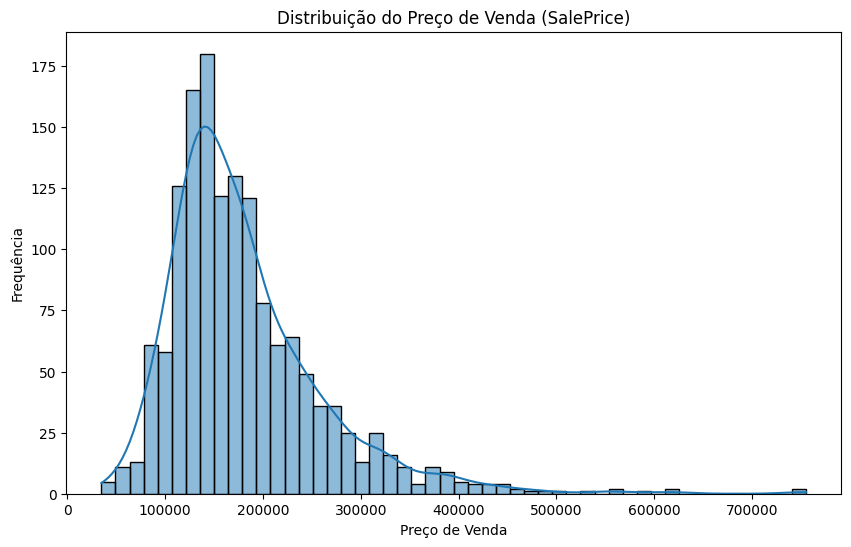

In [11]:
# Plotagem da distribuição do target
plt.figure(figsize=(10,6))
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribuição do Preço de Venda (SalePrice)')
plt.xlabel('Preço de Venda')
plt.ylabel('Frequência')
plt.show()

Conforme esperado para o problema, o gráfico de distribuição da variável alvo apresenta **assimetria positiva** (indicação de poucos imóveis com preços muito altos), algo típico para variáveis de preço. Essa assimetria viola a suposição de normalidade da variável dependente (ou dos resíduos) feita por muitos modelos lineares e impacta a performance de outros modelos baseados em distância. Para contornar esse problema, será feita a aplicação da **transformação logarítmica**. Isso irá "comprimir" a cauda direita e tornar o gráfico mais próximo de uma distribuição normal, afetando positivamente a performance preditiva do modelo e a validade das métricas.

In [12]:
# Aplicando log(1 + x) para garantir que valores zero (embora SalePrice não tenha) sejam tratados

y_train = np.log1p(y_train)
print("Transformação logarítmica aplicada ao target.")

Transformação logarítmica aplicada ao target.


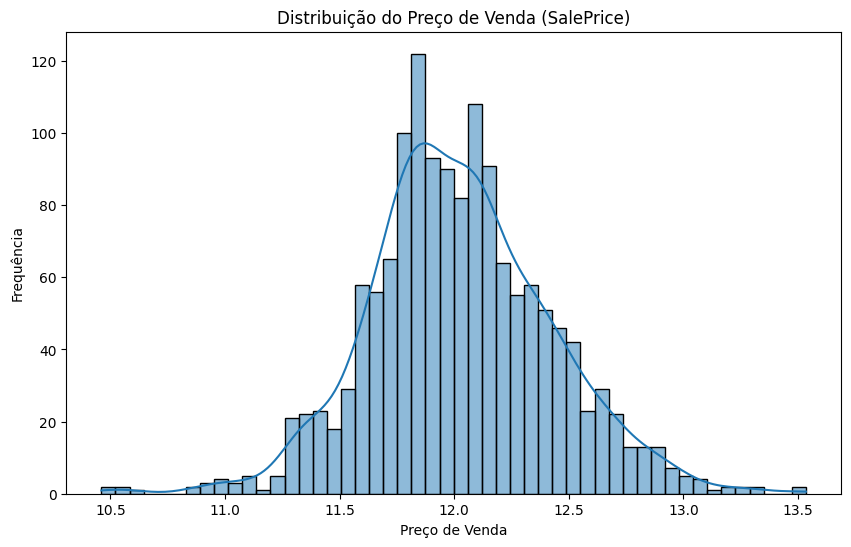

In [13]:
# Plotagem da distribuição do target
plt.figure(figsize=(10,6))
sns.histplot(y_train, kde=True, bins=50)
plt.title('Distribuição do Preço de Venda (SalePrice)')
plt.xlabel('Preço de Venda')
plt.ylabel('Frequência')
plt.show()

Agora, após a tranformação logarítmica, a variável alvo demonstra distribuição normal, conforme se vê no gráfico.

### Tranformação e Criação de *Features*

O dataset possui várias colunas que são mais informativas como categóricas/ordinais do que como numéricas, ou que podem ser combinadas. Serão criadas novas *features* combinando informações que podem ser importantes para as previsões do modelo. Em seguida, será feita a conversão de colunas numéricas que, na verdade, são categóricas em `object`.

In [14]:
# Criação de features
df_full['TotalSF'] = df_full['TotalBsmtSF'] + df_full['1stFlrSF'] + df_full['2ndFlrSF'] # Área total em pés quadrados
df_full['Age'] = df_full['YrSold'] - df_full['YearBuilt']  # Idade da casa na venda 

# Convertendo colunas numéricas que são categóricas em 'object'
df_full['YrSold'] = df_full['YrSold'].astype('object')
df_full['MoSold'] = df_full['MoSold'].astype('object')
df_full['MSSubClass'] = df_full['MSSubClass'].astype('object')

print("Novas features criadas e tipos de dados ajustados.")

Novas features criadas e tipos de dados ajustados.


In [15]:
print(f"Novo formato do DataFrame Completo: {df_full.shape}")

Novo formato do DataFrame Completo: (2919, 81)


### *Feature Engineering* Final

A última etapa antes de instanciar o modelo é converter as variáveis categóricas em variáveis numéricas, aplicando o `pd.get_dummies()`. Isso garantirá que todas as categorias sejam representadas em colunas binárias.
Após a codificação, o *dataset* será separado em dados de treino e teste, usando a contagem original de linhas.

In [16]:
# Aplicando a codificação categórica
df_full_encoded = pd.get_dummies(df_full)

# Separação do dataset em treino e teste
n_train = df_train.shape[0] 

X_train_final = df_full_encoded.iloc[:n_train, :]
X_test_final = df_full_encoded.iloc[n_train:, :]

# Verificando o formato final dos datasets
print(f"Formato final de X_train (Features de Treino): {X_train_final.shape}")
print(f"Formato final de X_test (Features de Teste): {X_test_final.shape}")

Formato final de X_train (Features de Treino): (1460, 334)
Formato final de X_test (Features de Teste): (1459, 334)


### Modelagem de Regressão e *Baseline*

Com a fase de pré-processamento completa, se iniciará a fase de modelagem, na qual se estabelecerá um **modelo *baseline*** e, em seguida, a utilização de modelos *ensemble* avançados para buscar a melhor performance na métrica **RMSE** (*Root Mean Squared Error*).
O modelo escolhido para o *baseline* é o ***Ridge***, um ótimo modelo para conjuntos de dados com alta dimensionalidade (muitas colunas após o *One-Hot Encoding*).

In [17]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Instanciando e treinando o modelo Ridge
ridge_model = Ridge(alpha=10.0, random_state=42)
ridge_model.fit(X_train_final, y_train)

# Fazendo as previsões e calculando o RMSE no conjunto de treino
y_train_pred = ridge_model.predict(X_train_final)

rmse_ridge = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred)))

print(f"RMSE do modelo em dólares: {rmse_ridge:.2f}")


RMSE do modelo em dólares: 23644.31


Já temos definida nossa métrica *baseline*, RMSE = $ $23.644,31$. Agora, vamos usar modelos de ensemble avançados para superar esta performance.

### Modelagem Avançada

Vamos utilizar o **XGBooster Regressor** que é um bom modelo para a maioria dos problemas de regressão, por sua robustez e alta performance.

In [18]:
import xgboost as xgb

# Instanciando e treinando o modelo XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
)

xgb_model.fit(X_train_final, y_train)

# Fazendo as previsões e calculando o RMSE
y_train_pred_xgb = xgb_model.predict(X_train_final)
rmse_xgb = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred_xgb)))

print(f"RMSE do modelo XGBoost em dólares: {rmse_xgb:.2f}")

RMSE do modelo XGBoost em dólares: 16547.52


### Análise do XGBoost

O modelo do XGBoost, ainda sem otimização, atingiu um RMSE de $ $16.547,52$, superando o *baseline* determinado.

<center>

|**Métrica**|**Ridge**|**XGBooster**|**Diferença**|
|:-:|:-:|:-:|:-:|
|RMSE|$ $23.644,31$|$ $16.547,52$|-$ $7.096,79$|
</center>

---

### Otimização do XGBoost

O objetivo agora é usar o `GridSearchCV` para encontrar a combinação de hiperparâmetros que minimize ainda mais o erro, otimizando o modelo.

In [20]:
from sklearn.model_selection import GridSearchCV

# Definindo os parâmetros para o Grid Search
params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)

# Configurando o Grid Search
grid_search = GridSearchCV(
    xgb_model,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Executando o Grid Search
grid_search.fit(X_train_final, y_train)
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Melhores parâmetros encontrados: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}


O `GridSearchCV` encontrou a seguinte combinação de parâmetros:

* `max_depth` = $3$: Profundidade rasa, indicando que o modelo se beneficia da generalização.
* `learning_rate` = $0.05$: Uma taxa de aprendizado baixa. O modelo prefere dar passos menores e mais cautelosos, algo comum em problemas de regressão complexos.
* `n_estimators` = $300$: Um número maior de árvores, compensando a taxa de aprendizado mais baixa.
* `subsample` = $0.9$: Usa 90% das linhas de dados para construir cada árvore, introduzindo aleatoriedade para melhorar a robustez e evitar *overfitting*.

Agora, vamos avaliar o desempenho final do melhor estimador de XGBoost encontrado e compará-lo com o *baseline*.

In [21]:
# Avaliando o melhor modelo encontrado pelo Grid Search
xgb_model_optimized = grid_search.best_estimator_

y_train_pred_optimized = xgb_model_optimized.predict(X_train_final)
rmse_xgb_optimized = np.sqrt(mean_squared_error(np.expm1(y_train), np.expm1(y_train_pred_optimized)))
print(f"RMSE do modelo XGBoost otimizado em dólares: {rmse_xgb_optimized:.2f}")

RMSE do modelo XGBoost otimizado em dólares: 14046.04


A otimização do XGBoost o consolida como um bom modelo para nosso projeto.

<center>

|**Modelo**|**RMSE**|**Redução de Erro**|
|:-:|:-:|:-:|
|Ridge (*Baseline*)|$ $23.644,31$|-|
|XGBoost (Não Otimizado)|$ $16.547,52$|≈$30$%|
|XGBoost (Otimizado)|$ $14.046,04$|≈$40$%|
</center>

O erro médio de previsão do preço de venda foi reduzido em mais de $40$% em comparação com o modelo *baseline* de Ridge. Um erro de $ $14.046,04$ é um excelente resultado para este *dataset* complexo.

Agora, antes da serialização do modelo, será feita a identificação das *features* mais importantes para o modelo selecionado.

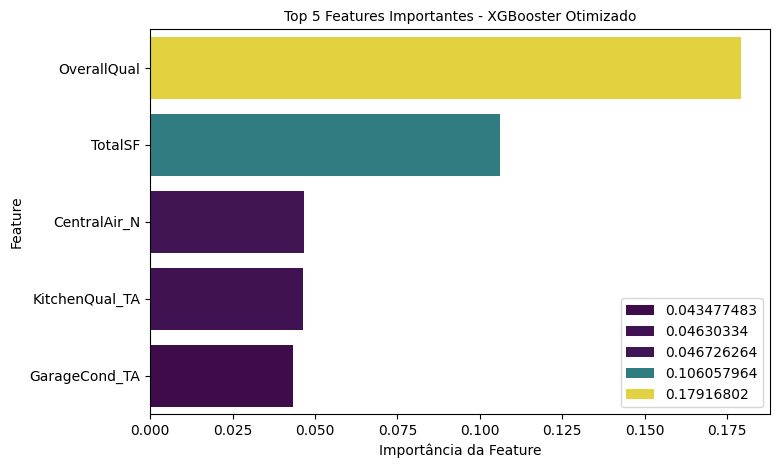

In [22]:
# extraindo as principais features do modelo otimizado
feature_importances = pd.Series(xgb_model_optimized.feature_importances_, index=X_train_final.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# plotando as 5 principais features
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importances.head(5).values, y=feature_importances.head(5).index, palette='viridis', hue=feature_importances.head(5).values)
plt.title('Top 5 Features Importantes - XGBooster Otimizado', fontsize=10)
plt.xlabel('Importância da Feature')
plt.ylabel('Feature')
plt.show()

O gráfico apresenta as 5 *features* mais críticas utilizadas pelo modelo para prever os preços:
* **OverallQual** 
  - Qualidade Geral: O fator isolado mais importante é a avaliação geral da qualidade do material e acabamento da casa (faz sentido no mercado imobiliário).
* **TotalSF**
  - Área Total: A *feature* que criada (`TotalBsmtSF` + `1stFlrSF` + `2ndFlrSF`). O tamanho total da área habitável é o segundo fator mais relevante.
* **CentralAir_N**
  - Ausência de Central de Ar: A ausência de ar condicionado central (`CentralAir` codificado) é um preditor forte. O modelo dá peso negativo a essa *feature* (embora o gráfico mostre apenas a importância absoluta).
* **KitchenQual_TA**
  - Qualidade da Cozinha: A avaliação da cozinha como "*Typical*/*Average*" é um fator importante.
* **GarageCond_TA**
  - Condição da Garagem: A condição da garagem ser "*Typical*/*Average*" também tem um peso significativo.

**Conclusão**: O modelo prioriza qualidade percebida (`OverallQual`), tamanho (`TotalSF`) e condições/acabamentos (Cozinha, Garagem, Ar Central).

---

### Serialização do Modelo

A última etapa do projeto é salvar o modelo vencedor para uso futuro (*deploy*).

In [23]:
import joblib

# Salvando o modelo otimizado
model_filename = 'xgb_model_optimized.pkl'
model_path = f"../models/{model_filename}"

joblib.dump(xgb_model_optimized, model_path)
print(f"Modelo serializado e salvo em: {model_path}")

# Teste de rápido de verificação
try:
    loaded_model = joblib.load(model_path)
    print(f"Modelo carregado: {type(loaded_model)}")
    print("\nVerificação concluída. Pronto para deploy.")
except Exception as e:
    print(f"Erro ao carregar o modelo: {e}")

Modelo serializado e salvo em: ../models/xgb_model_optimized.pkl
Modelo carregado: <class 'xgboost.sklearn.XGBRegressor'>

Verificação concluída. Pronto para deploy.
